# Capstone Regression Project

Pedro J. Salinas [pedrojsalinas@gmail.com](mailto:pedrojsalinas@gmail.com)

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

# from bs4 import BeautifulSoup
# import requests

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv("../data/01_eda.csv")

In [3]:
df.shape

(29182, 26)

In [4]:
df.head()

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,yr_old,city
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,53,Renton
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,71,Seattle
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,65,Seattle
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,11,Seattle
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,9,Issaquah


## Modeling

### Preparation Analysis

Taking `price` as the target

In [5]:
df['price'].describe()

count    2.918200e+04
mean     1.114620e+06
std      9.041000e+05
min      2.736000e+04
25%      6.450000e+05
50%      8.670000e+05
75%      1.310000e+06
max      3.075000e+07
Name: price, dtype: float64

In [6]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.608931
sqft_above       0.538505
bathrooms        0.483037
sqft_patio       0.316375
bedrooms         0.286032
sqft_garage      0.261977
sqft_basement    0.243633
floors           0.201533
yr_old           0.139184
yr_built         0.107777
lat              0.100241
sqft_lot         0.085368
yr_renovated     0.083848
long             0.055249
Name: price, dtype: float64

`sqft_living` correlated better with `price` than any other feature

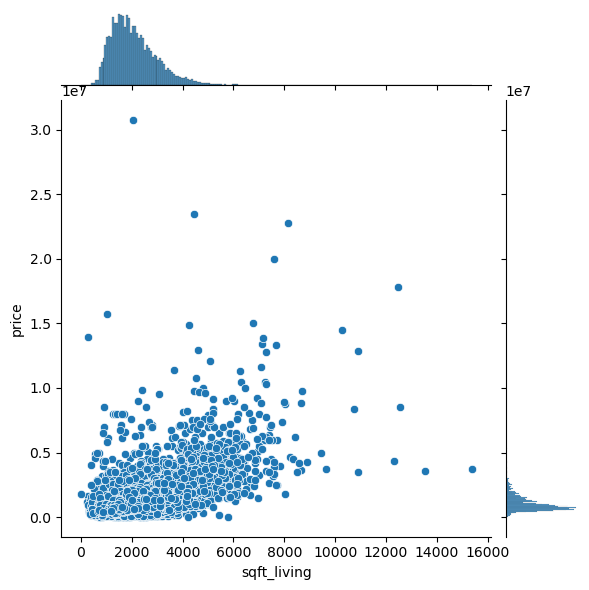

In [7]:
sns.jointplot(data=df, x='sqft_living', y='price', palette='set2')
plt.savefig('../images/relationship_between_price_and_sqft_living.png')
plt.show();

* In the top histogram `sqft_living` we can see values are skew to the left, with a very long tail to the right to reflect those big houses.
* To your right the `price` histogram is concentrated on prices less than \$500k, and the scatter points (houses) well beyond that area represented by a very thin tail

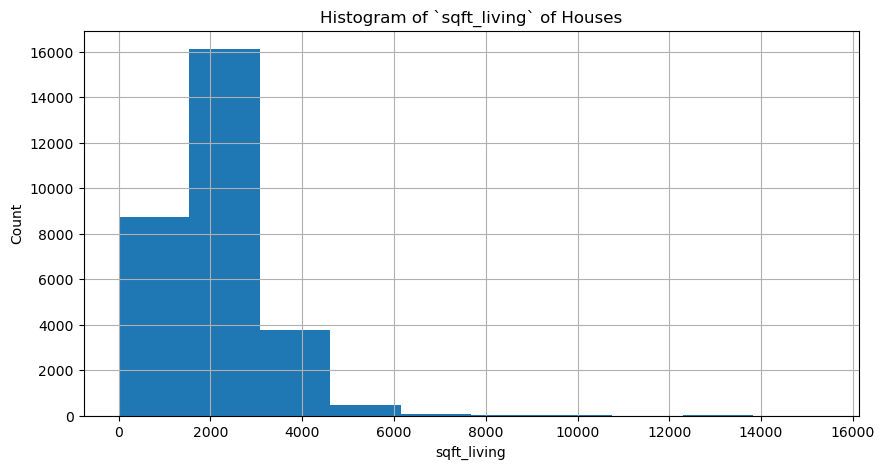

In [8]:
ax = df['sqft_living'].hist(figsize=(10,5))
ax.set_title('Histogram of `sqft_living` of Houses')
ax.set_xlabel('sqft_living')
ax.set_ylabel('Count')

plt.savefig('../images/histogram_sqft_living.png')

plt.show();

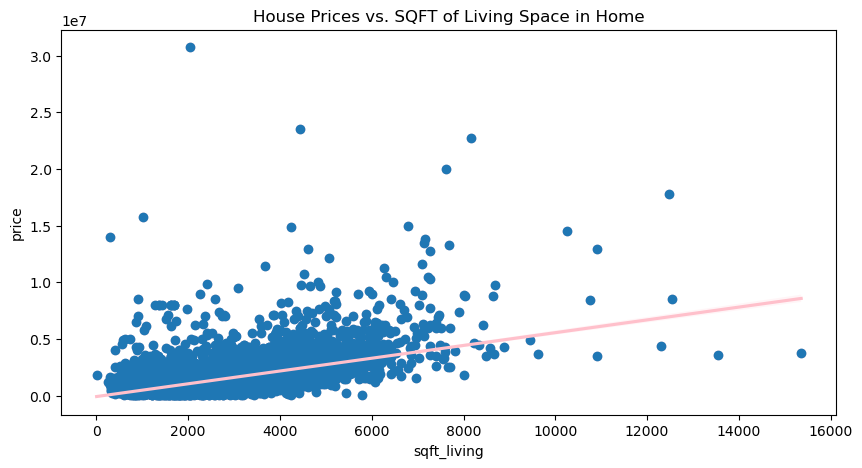

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.regplot(data=df, x=df['sqft_living'], y=df['price'], color="pink")
ax.scatter(df['sqft_living'], df['price'])
ax.set_title("House Prices vs. SQFT of Living Space in Home")

plt.savefig('../images/scatter_and_regplot_price_vs_sqft_living.png')
plt.show();

### Baseline Model

In [10]:
# Create a baseline model using `sqft_living` to prdict the `price`
y = df["price"]
X = df[["sqft_living"]]

In [11]:
results = sm.OLS(y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                 1.720e+04
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        20:26:15   Log-Likelihood:            -4.3487e+05
No. Observations:               29182   AIC:                         8.697e+05
Df Residuals:                   29180   BIC:                         8.698e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.592e+04   1.01e+04     -8.531      

In [12]:
house_price_preds = results.predict()
predicted_mean_price = np.sqrt(((df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $717,141


* Our model is statistically significant, with a p-value of well below the standard alpha of 0.05
* The model explain about 37% of the variance in Price
* The model coeficients (`const` and `sqft_living`) are both statistically significant, with p-values well below 0.05
* If we have a home with 0 square feet of `sqft_living` it will cost about $-\$74k$
* For each increase of 1 square foot of `sqft_living`, we see an associated increase in `price` of about $563

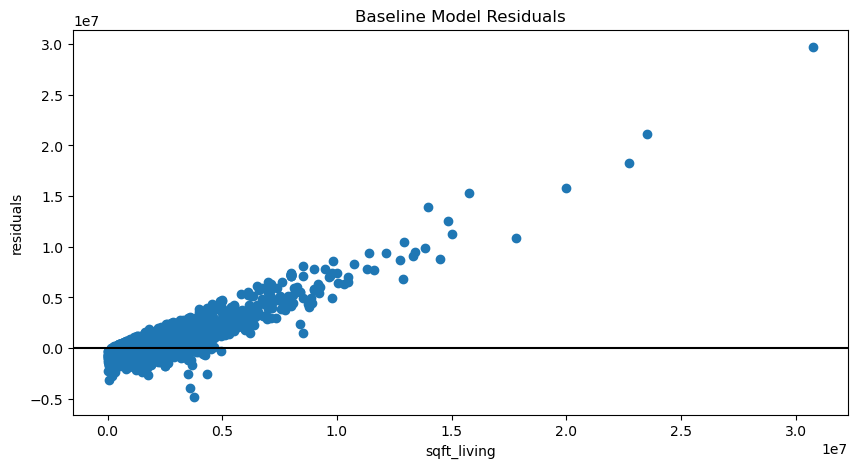

In [13]:
# Model Residuals
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(df["price"], results.resid)
ax.axhline(y=0, color="black")
ax.set_title('Baseline Model Residuals')
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

plt.savefig('../images/residuals_baseline_model.png')
plt.show();

### Second Model

In [14]:
# Drop target `price`, and get all the numerical features of the dataset
X_2 = df.drop("price", axis=1).select_dtypes('number')

In [15]:
X_2

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,yr_old
0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,0,47.461975,-122.19052,53
1,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,0,47.711525,-122.35591,71
2,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,0,47.502045,-122.22520,65
3,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,0,47.566110,-122.29020,11
4,2,2.0,1120,758,2.0,1120,550,550,30,2012,0,47.532470,-122.07188,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,5,2.0,1910,4000,1.5,1600,1130,0,210,1921,0,47.664740,-122.32940,100
29178,3,2.0,2020,5800,2.0,2020,0,0,520,2011,0,47.565610,-122.38851,10
29179,3,2.0,1620,3600,1.0,940,920,240,110,1995,0,47.610395,-122.29585,27
29180,3,2.5,2570,2889,2.0,1830,740,480,100,2006,0,47.449490,-122.18908,16


In [16]:
results_2 = sm.OLS(y, sm.add_constant(X_2)).fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     1789.
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        20:26:16   Log-Likelihood:            -4.3259e+05
No. Observations:               29182   AIC:                         8.652e+05
Df Residuals:                   29167   BIC:                         8.653e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.207e+07   1.65e+06    -13.353

In [17]:
house_price_preds = results_2.predict()
predicted_mean_price = np.sqrt(((df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $663,173


* The model is statistically significant overall, with a F-statistic p-value well below 0.05
* The model explains about 46.2% of the variance in `price`.
* * The fact that we went one predictor to 14 predictors, and increased Adj R-Squared by about 9.1% indicate that it is a better model.
* The p-value for the `sqft_lot` is more that the acceptable alpha of 0.05. It's a candidate to be dropped.

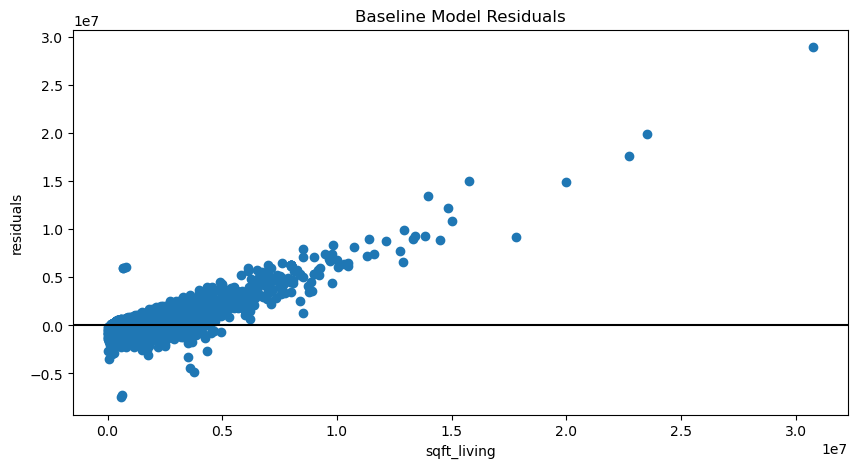

In [18]:
# The Residuals
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(df["price"], results_2.resid)
ax.axhline(y=0, color="black")
ax.set_title('Baseline Model Residuals')
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

plt.savefig('../images/model_2_residuals_baseline_model.png')
plt.show();

#### Partial Regression Plots

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


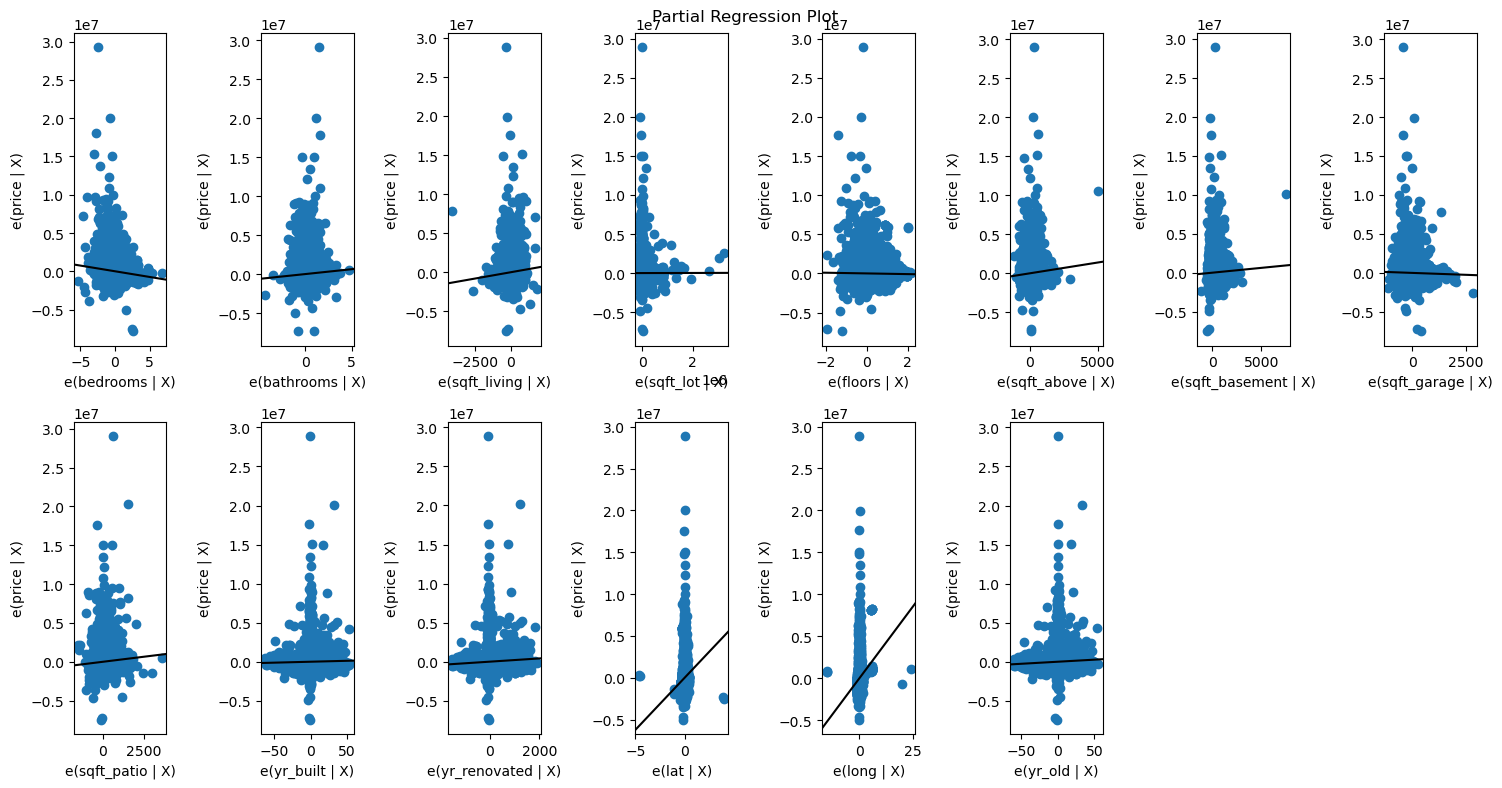

In [19]:
fig = plt.figure(figsize=(15,8))

sm.graphics.plot_partregress_grid(
    results_2,
    exog_idx = list(X_2.columns.values),
    grid=(2,8),
    fig=fig
)
plt.show();

* As we can see, as we have added more predictors, the partial regression plot for each individual one doesn't add enough to the performance of the model. 
* Other than `bathrooms`, `sqft_living`, `sqft_above`, and `long`, we're seeing that several of them have slopes near zero.
* We might have include too many predictors, and we should consider removing some of them.
* p-value for `sqft_lot` is more than the permissible 0.05. It's a candidate to drop.

### Third Model

In [20]:
df.columns

Index(['selldate', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition',
       'grade', 'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'address',
       'lat', 'long', 'yr_old', 'city'],
      dtype='object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29182 entries, 0 to 29181
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   selldate       29182 non-null  object 
 1   price          29182 non-null  float64
 2   bedrooms       29182 non-null  int64  
 3   bathrooms      29182 non-null  float64
 4   sqft_living    29182 non-null  int64  
 5   sqft_lot       29182 non-null  int64  
 6   floors         29182 non-null  float64
 7   waterfront     29182 non-null  object 
 8   greenbelt      29182 non-null  object 
 9   nuisance       29182 non-null  object 
 10  view           29182 non-null  object 
 11  condition      29182 non-null  object 
 12  grade          29182 non-null  object 
 13  heat_source    29182 non-null  object 
 14  sewer_system   29182 non-null  object 
 15  sqft_above     29182 non-null  int64  
 16  sqft_basement  29182 non-null  int64  
 17  sqft_garage    29182 non-null  int64  
 18  sqft_p

In [22]:
# Inspecting features that are not of the data type `numerical`
df[['waterfront', 'greenbelt', 'nuisance', 'view', 'condition','grade', 'heat_source', 'sewer_system', 'city']].value_counts()

waterfront  greenbelt  nuisance  view     condition  grade          heat_source  sewer_system  city       
NO          NO         NO        NONE     Average    7 Average      Gas          PUBLIC        Seattle        707
                                                     8 Good         Gas          PUBLIC        Seattle        695
                                                                    Electricity  PUBLIC        Seattle        506
                                                     7 Average      Oil          PUBLIC        Seattle        450
                                          Good       7 Average      Gas          PUBLIC        Seattle        449
                                                                                                             ... 
                                                     6 Low Average  Oil          PRIVATE       Tukwila          1
                                                                                 PUBLIC        

In [23]:
# Dummyfiying Categorical-String Variables
cat_columns = ["waterfront", "greenbelt", "nuisance", "view", "condition", "grade", "heat_source", "sewer_system", "city"]
dummies_df = pd.get_dummies(data=df, columns=cat_columns, drop_first=True)

In [24]:
dummies_df.columns

Index(['selldate', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
       'yr_built', 'yr_renovated', 'address', 'lat', 'long', 'yr_old',
       'waterfront_YES', 'greenbelt_YES', 'nuisance_YES', 'view_EXCELLENT',
       'view_FAIR', 'view_GOOD', 'view_NONE', 'condition_Fair',
       'condition_Good', 'condition_Poor', 'condition_Very Good',
       'grade_11 Excellent', 'grade_12 Luxury', 'grade_13 Mansion',
       'grade_2 Substandard', 'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair',
       'grade_6 Low Average', 'grade_7 Average', 'grade_8 Good',
       'grade_9 Better', 'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED', 'city_Auburn',
       'city_Baring', 'city_Bellevue', 'city_Black Diamond', 

In [25]:
dummies_df.dtypes

selldate              object
price                float64
bedrooms               int64
bathrooms            float64
sqft_living            int64
                      ...   
city_Snoqualmie        uint8
city_Tukwila           uint8
city_Vashon            uint8
city_Woodinville       uint8
city_Yarrow Point      uint8
Length: 91, dtype: object

In [26]:
# `selldate`, `price`, and `address` are exclude from the analysis
X_3 = dummies_df.drop(labels=["selldate", "price", "address"], axis=1)
y = dummies_df['price']

In [27]:
X_3

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,...,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,...,0,0,0,0,0,0,0,0,0,0
1,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,...,0,0,1,0,0,0,0,0,0,0
2,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,...,0,0,1,0,0,0,0,0,0,0
3,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,...,0,0,1,0,0,0,0,0,0,0
4,2,2.0,1120,758,2.0,1120,550,550,30,2012,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,5,2.0,1910,4000,1.5,1600,1130,0,210,1921,...,0,0,1,0,0,0,0,0,0,0
29178,3,2.0,2020,5800,2.0,2020,0,0,520,2011,...,0,0,1,0,0,0,0,0,0,0
29179,3,2.0,1620,3600,1.0,940,920,240,110,1995,...,0,0,1,0,0,0,0,0,0,0
29180,3,2.5,2570,2889,2.0,1830,740,480,100,2006,...,0,0,0,0,0,0,0,0,0,0


In [28]:
results_3 = sm.OLS(y, sm.add_constant(X_3)).fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     634.0
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        20:26:23   Log-Likelihood:            -4.2601e+05
No. Observations:               29182   AIC:                         8.522e+05
Df Residuals:                   29093   BIC:                         8.529e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [29]:
house_price_preds = results_3.predict()
predicted_mean_price = np.sqrt(((df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $529,288


* The model is statistically significant overall, with a F-statistic p-value well below 0.05
* The model explains about 65.6% of the variance in `price`.
* * The fact that we went 14 predictors to 88, and increased Adj R-Squared by about 19.4% indicate that it is a better model.
* The p-value some of the features in the model are more than the acceptable alpha of 0.5. Those are candidates to drop.

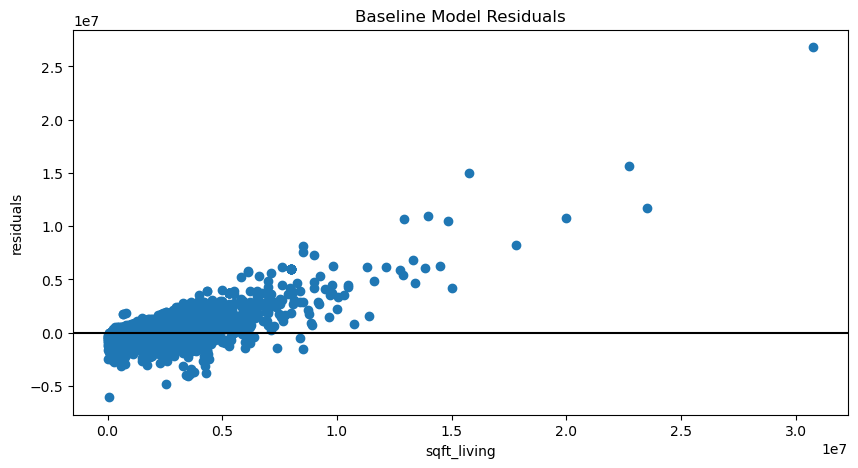

In [30]:
# The Residuals
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(df["price"], results_3.resid)
ax.axhline(y=0, color="black")
ax.set_title('Baseline Model Residuals')
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

plt.savefig('../images/model_3_residuals_baseline_model.png')
plt.show();

In [31]:
# p-values Analysis
pvalues_df = pd.DataFrame(results_3.pvalues, columns=['p-value'])
pvalues_df['p < 0.05'] = pvalues_df['p-value'] < 0.05
pvalues_df

,p-value,p < 0.05
const,8.823379e-01,False
bedrooms,1.515151e-14,True
bathrooms,5.176993e-21,True
sqft_living,1.148189e-07,True
sqft_lot,4.388490e-16,True
...,...,...
city_Snoqualmie,5.802684e-02,False
city_Tukwila,9.895453e-01,False
city_Vashon,9.864227e-01,False
city_Woodinville,4.889207e-05,True


In [32]:
# Features to drop
pvalues_df[pvalues_df['p < 0.05'] != True]

,p-value,p < 0.05
const,0.882338,False
yr_built,0.258309,False
yr_old,0.740286,False
nuisance_YES,0.214169,False
condition_Poor,0.231196,False
grade_2 Substandard,0.673684,False
heat_source_Electricity/Solar,0.282060,False
heat_source_Gas,0.128608,False
heat_source_Oil,0.678122,False
heat_source_Oil/Solar,0.955284,False


In [33]:
# features whose p-values are > 0.05, and are canditates to be dropped.
pvalues_df[pvalues_df['p < 0.05'] != True].index

Index(['const', 'yr_built', 'yr_old', 'nuisance_YES', 'condition_Poor',
       'grade_2 Substandard', 'heat_source_Electricity/Solar',
       'heat_source_Gas', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PUBLIC RESTRICTED', 'city_Auburn',
       'city_Baring', 'city_Black Diamond', 'city_Burien', 'city_Carnation',
       'city_Covington', 'city_Des Moines', 'city_Duvall', 'city_Enumclaw',
       'city_Federal Way', 'city_Hobart', 'city_Kent', 'city_Maple Valley',
       'city_Normandy Park', 'city_North Bend', 'city_Pacific', 'city_Preston',
       'city_Ravensdale', 'city_Renton', 'city_SeaTac', 'city_Snoqualmie',
       'city_Tukwila', 'city_Vashon'],
      dtype='object')

### Fourth Model

In [34]:
# drop features whose p-values are > 0.05
to_drop = ['yr_built', 'yr_old', 'nuisance_YES', 'condition_Poor',
       'grade_2 Substandard', 'heat_source_Electricity/Solar',
       'heat_source_Gas', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PUBLIC RESTRICTED', 'city_Auburn',
       'city_Baring', 'city_Black Diamond', 'city_Burien', 'city_Carnation',
       'city_Covington', 'city_Des Moines', 'city_Duvall', 'city_Enumclaw',
       'city_Federal Way', 'city_Hobart', 'city_Kent', 'city_Maple Valley',
       'city_Normandy Park', 'city_North Bend', 'city_Pacific', 'city_Preston',
       'city_Ravensdale', 'city_Renton', 'city_SeaTac', 'city_Snoqualmie',
       'city_Tukwila', 'city_Vashon']

In [35]:
X_3

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,...,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,...,0,0,0,0,0,0,0,0,0,0
1,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,...,0,0,1,0,0,0,0,0,0,0
2,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,...,0,0,1,0,0,0,0,0,0,0
3,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,...,0,0,1,0,0,0,0,0,0,0
4,2,2.0,1120,758,2.0,1120,550,550,30,2012,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,5,2.0,1910,4000,1.5,1600,1130,0,210,1921,...,0,0,1,0,0,0,0,0,0,0
29178,3,2.0,2020,5800,2.0,2020,0,0,520,2011,...,0,0,1,0,0,0,0,0,0,0
29179,3,2.0,1620,3600,1.0,940,920,240,110,1995,...,0,0,1,0,0,0,0,0,0,0
29180,3,2.5,2570,2889,2.0,1830,740,480,100,2006,...,0,0,0,0,0,0,0,0,0,0


In [36]:
X_4 = X_3.drop(labels=to_drop, axis=1)

In [37]:
X_4.shape

(29182, 54)

In [38]:
results_4 = sm.OLS(y, sm.add_constant(X_4)).fit()
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     1026.
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        20:26:25   Log-Likelihood:            -4.2608e+05
No. Observations:               29182   AIC:                         8.523e+05
Df Residuals:                   29127   BIC:                         8.527e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [39]:
house_price_preds = results_4.predict()
predicted_mean_price = np.sqrt(((df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $530,657


* The model is statistically significant overall, with a F-statistic p-value well below 0.05
* The model explains about 65.5% of the variance in `price`.
* * The fact that Adj R-Squared is almost the same than previous model (65.6%) indicates that it is not better than the previous one.
* p-values for the dataframe features are under the acceptable 0.05

## Asumptions

### Linearity

The dependent variable (y) is assume to be a function of the independent variables (X, features)

The desired outcome is that points are symmetrically distributed around a diagonal line in the `observed vs. predicted` plot or around a horizontal line in the `residuals vs. predicted`. In both cases with a roughly constant variance.

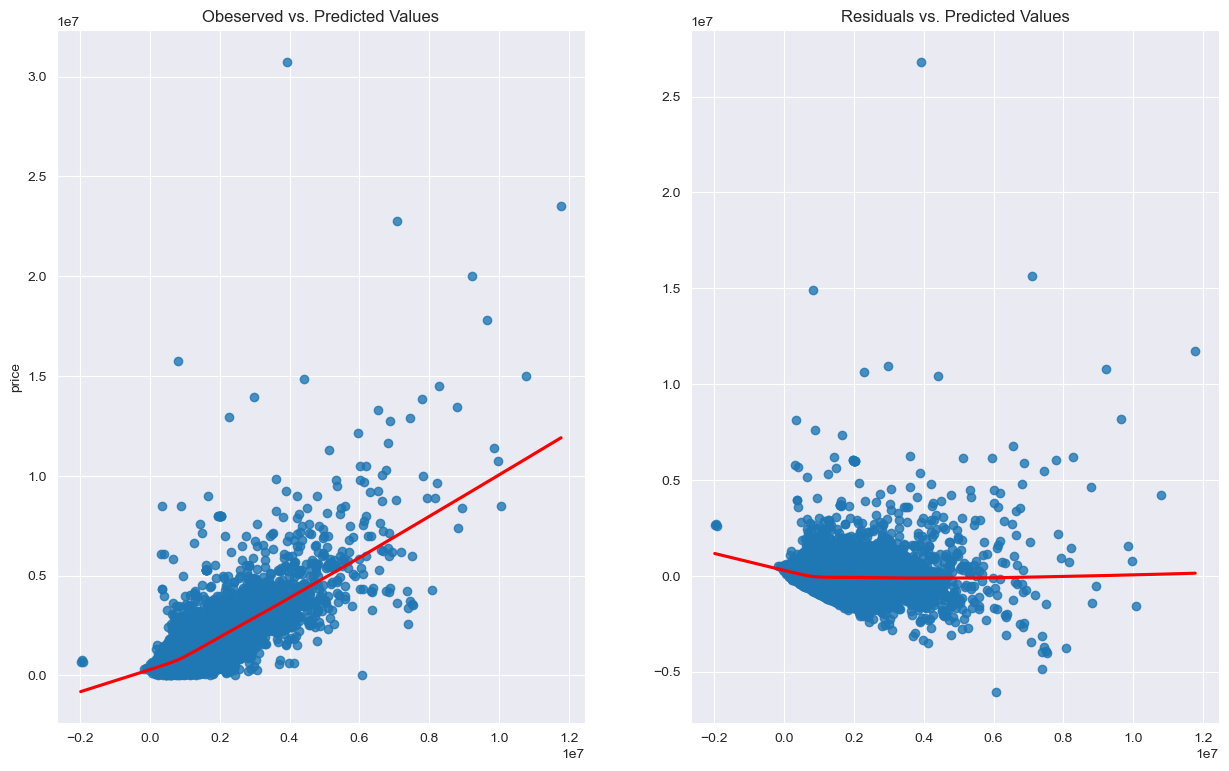

In [40]:
%config InlineBacked.figure_format = 'retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumptions of linearity in a linear regression models.
    '''
    
    fitted_vals = model.predict()
    resids = model.resid
    
    fig, ax = plt.subplots(1, 2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Obeserved vs. Predicted Values')
    
    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values')
    
    plt.savefig('../images/assumption_linearity_02_modeling.png')
    
linearity_test(results_4, y)

The inspection of the plots shows that the linearity assumption is not satisfied.
Potential solutions:
* non-linear transformations to dependent/independent variables
* adding extra features which are a transformation of the already used ones (for example squared version)
* adding features that were not considered before

### Expectation (mean) of residuals is zero

In [41]:
# Linear Regression Residuals
results_4.resid.mean()

1.566157141938723e-07

We can assume the expectation of residuals is zero.

### Multicollinearity

One scenario to watch out for is the ‘dummy variable trap’ — when we use dummy variables to encode a categorical feature and do not omit the baseline level from the model. This results in a perfect correlation between the dummy variables and the constant term.

* We can detect multicollinearity using the variance inflaction factor (VIF)
* If no features are correlated, then all values for VIF will be 1.

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [43]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_4.values, i) for i in range(X_4.shape[1])]
vif["features"] = X_4.columns
vif.round(1)

,VIF Factor,features
0,26.8,bedrooms
1,24.9,bathrooms
2,121.0,sqft_living
3,1.3,sqft_lot
4,18.3,floors
5,89.7,sqft_above
6,7.0,sqft_basement
7,4.8,sqft_garage
8,2.4,sqft_patio
9,1.1,yr_renovated


* To deal with Multicolinearity as a rule of thumb we should remove features with VIF larger than 10 (5 is also common). 
* Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

### Homoscedasticity

To investigate if the residuals are homoscedastic, we can look at a plot of residuals (or standardized residuals) vs. predicted (fitted) values.

We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

In [44]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
# import seaborn as sns 
# import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n\n Residuals plots ----')




 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.406351e+03
p-value                        1.119786e-258
f-value                         2.731062e+01
f p-value                      1.055568e-265

 Goldfeld-Quandt test ----
                value
F statistic  1.017806
p-value      0.143682


 Residuals plots ----


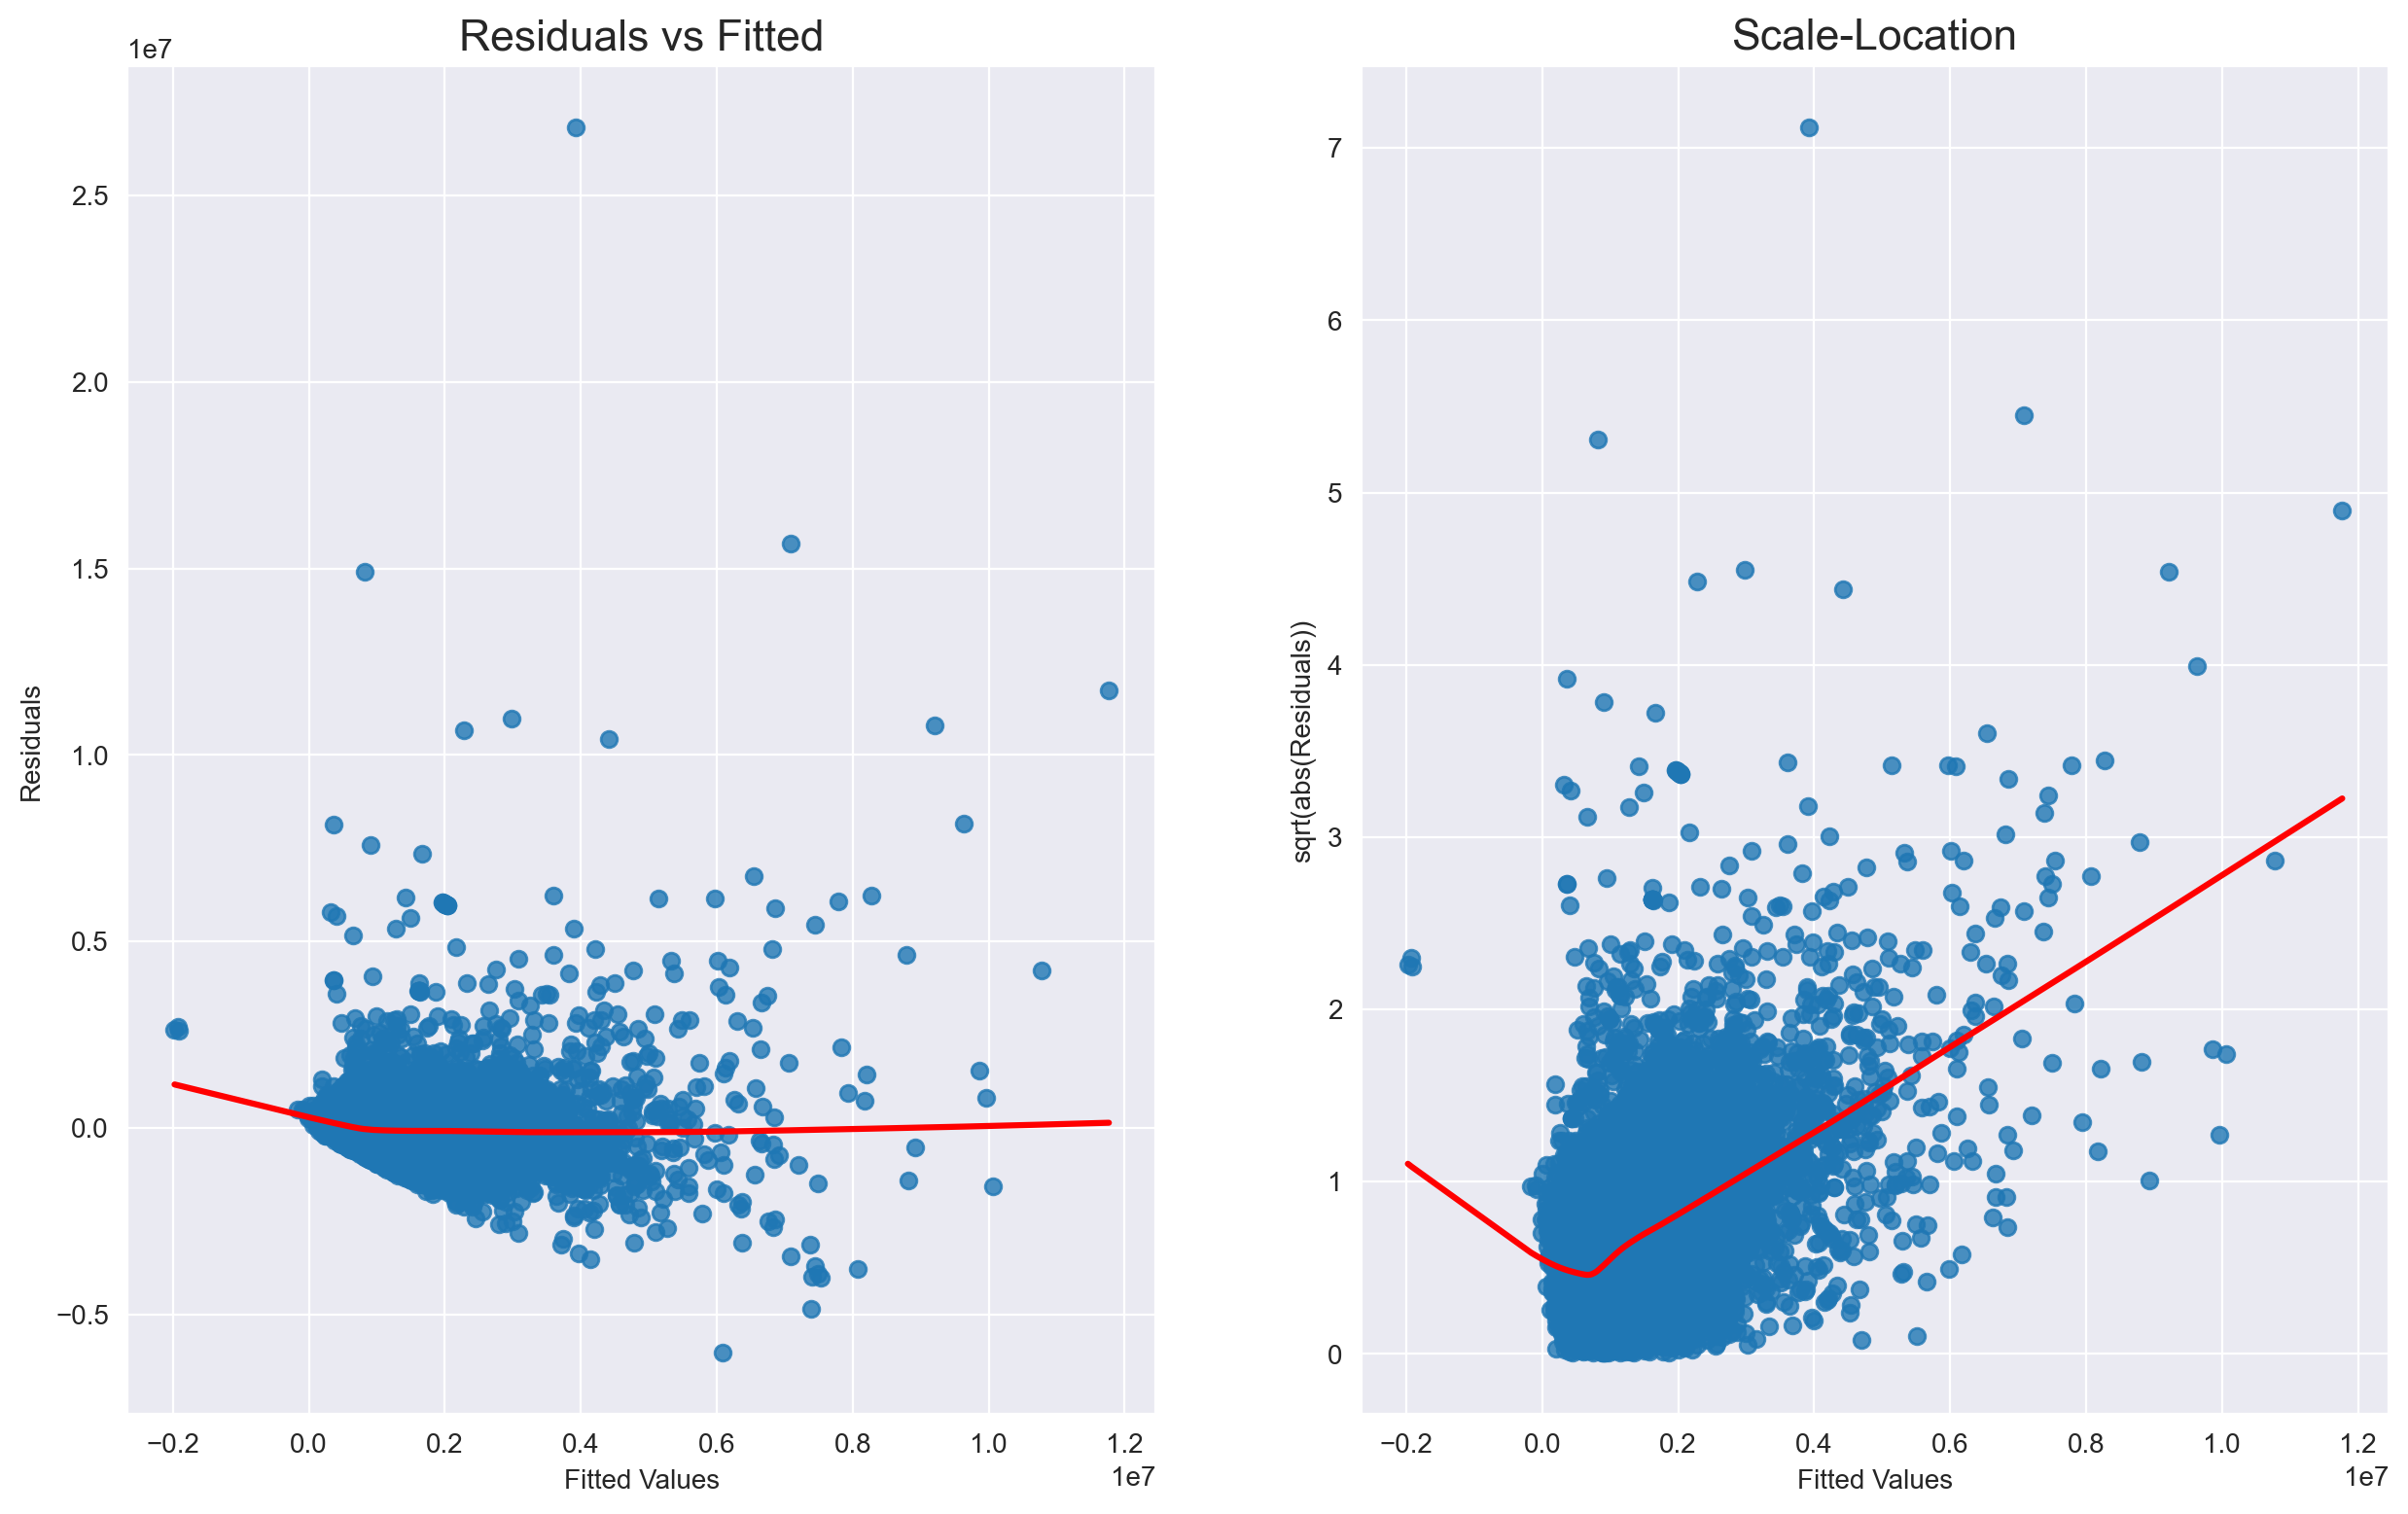

In [45]:
homoscedasticity_test(results_4)

The results indicate that the assumption is not satisfied and we should reject the hypothesis of homoscedasticity.

Potential solutions:
* log transformation of the dependent variable

### No autocorrelation of residuals

The test statistic provides a test for significant residual autocorrelation at lag 1. The Durbin-Watson (DW) statistic is approximately equal to 2(1-a), where a is the lag 1 residual autocorrelation.

Some notes on the Durbin-Watson test:
* the test statistic always has a value between 0 and 4
* value of 2 means that there is no autocorrelation in the sample
* values < 2 indicate positive autocorrelation, values > 2 negative one.

In [46]:
import statsmodels.tsa.api as smt

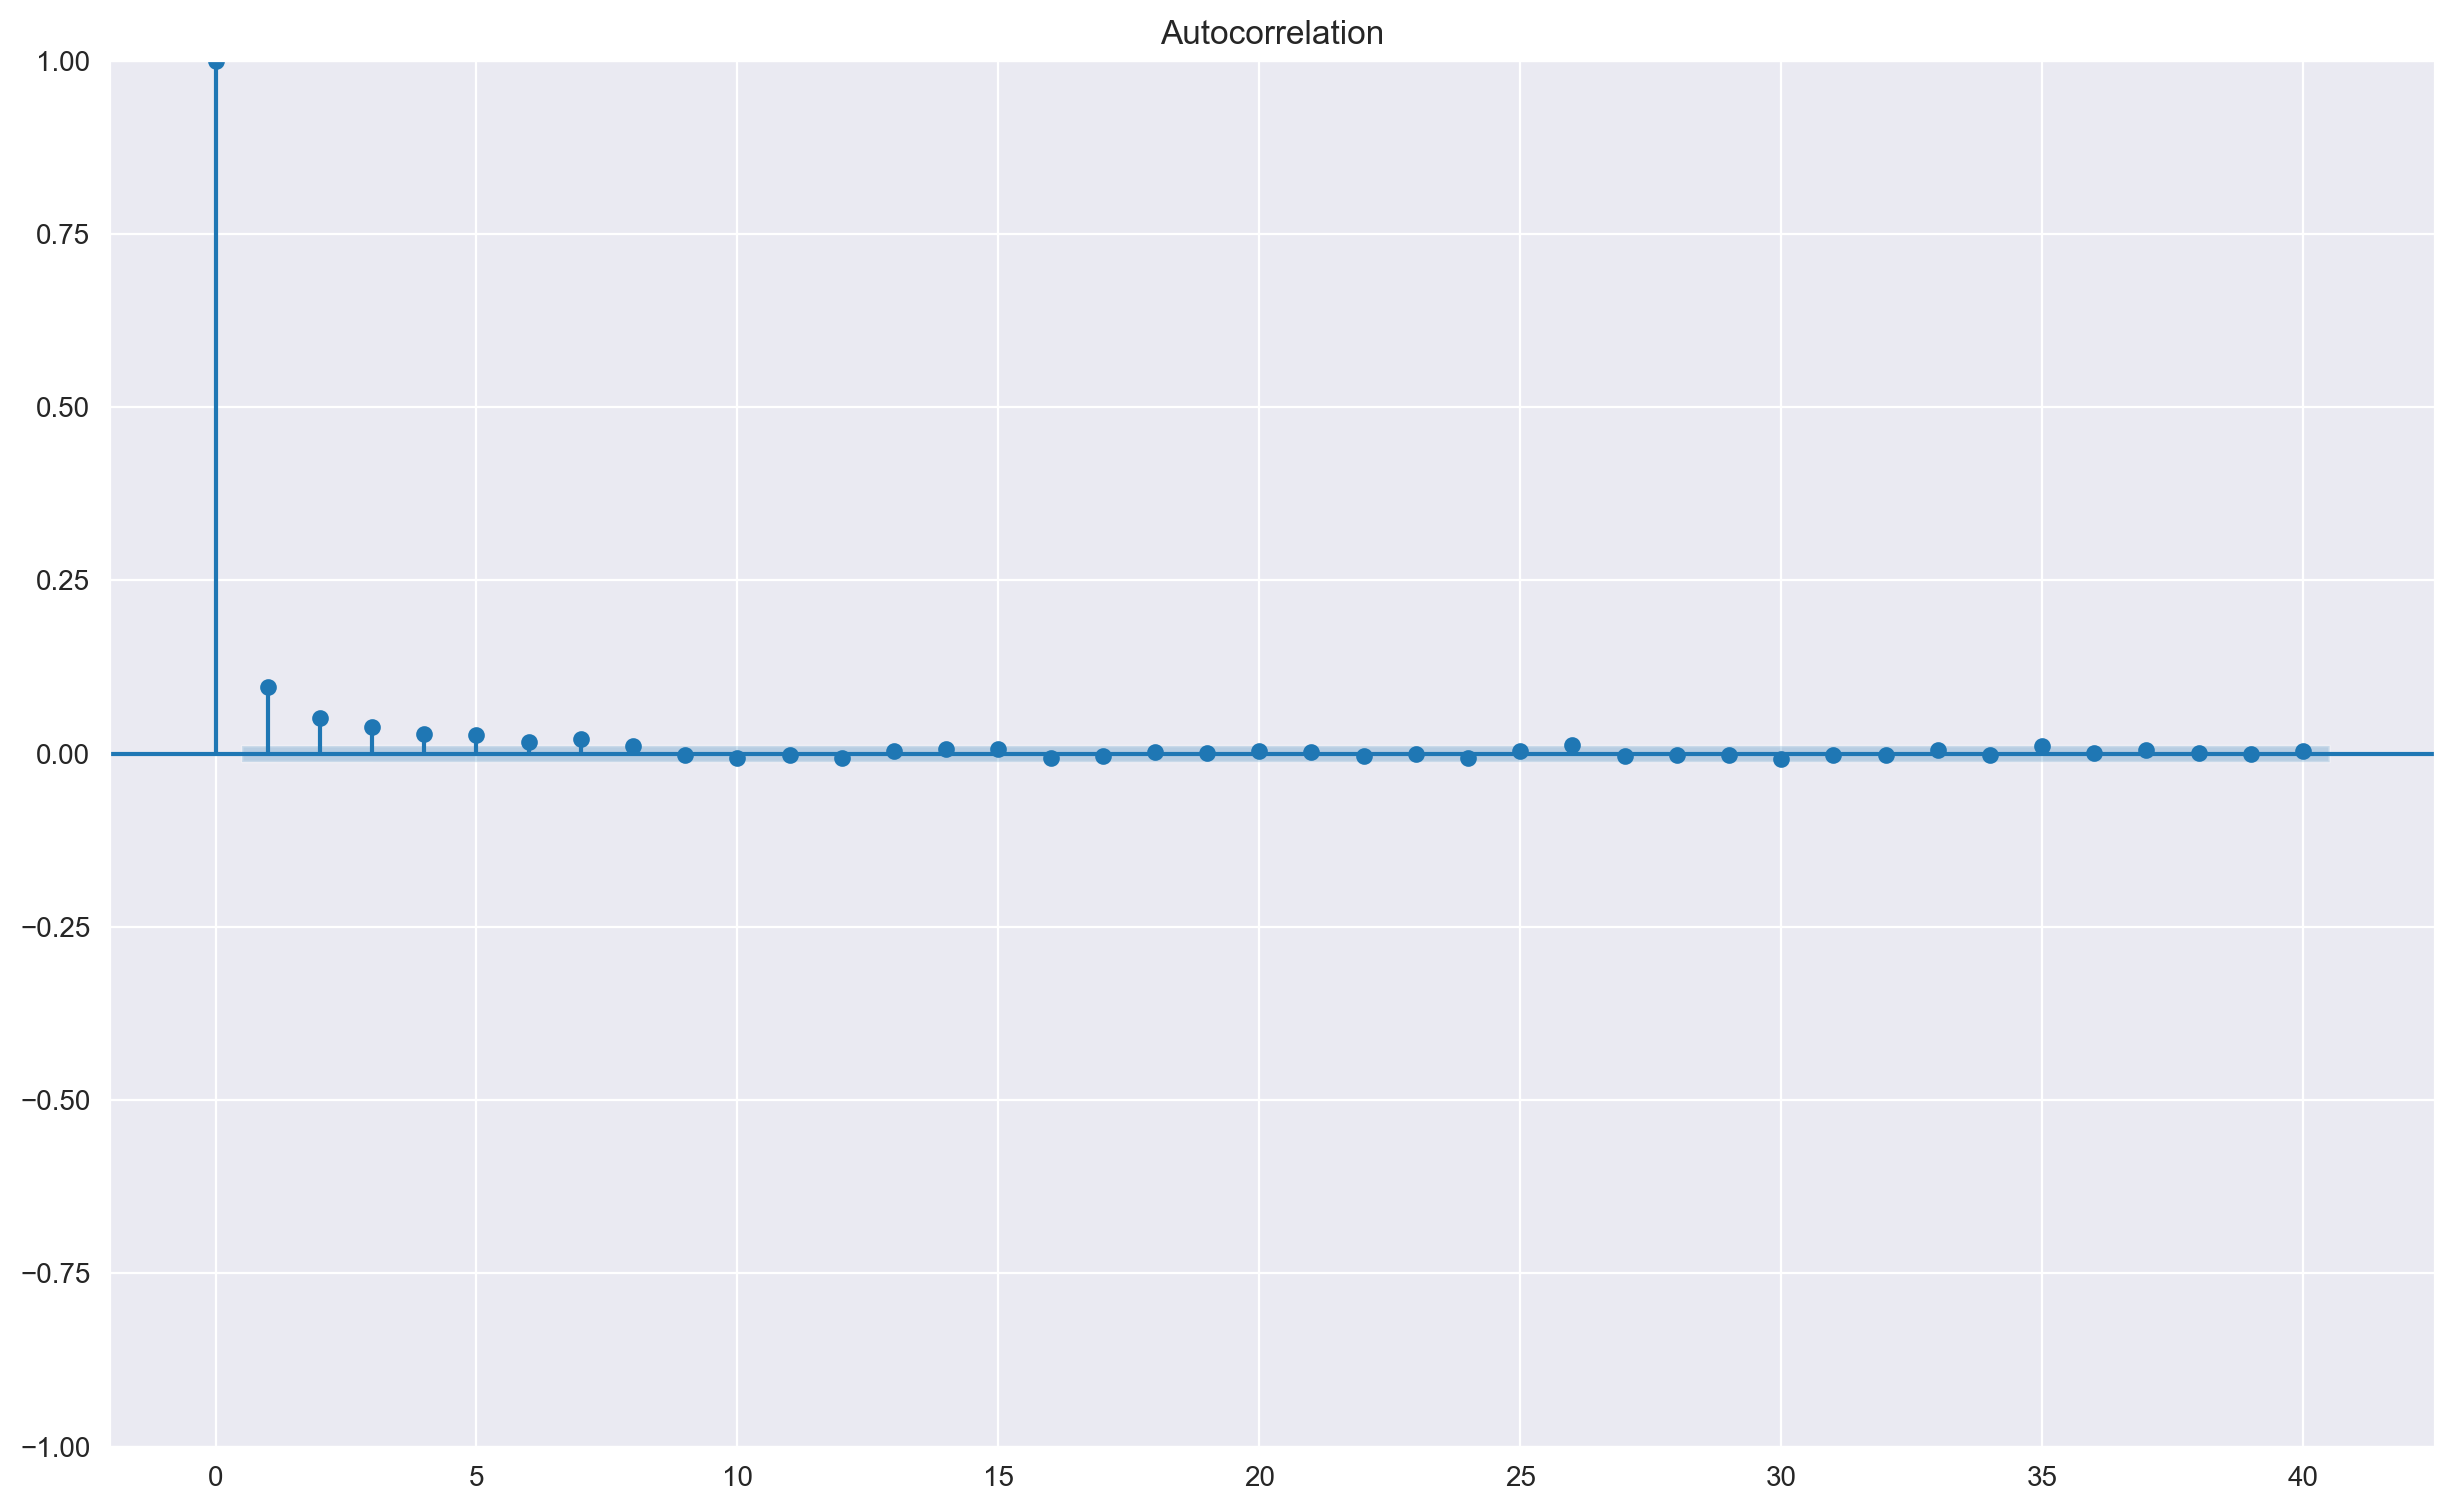

In [47]:
acf = smt.graphics.plot_acf(results_4.resid, lags=40 , alpha=0.05)

plt.savefig('../images/autocorrelation_model_4_durbin_watson_test.png')
acf.show();

Or, looking at the default summary output of the linear regression model:
* Durbin-Watson: 1.807
* DW < 2 means there is positive correlation between the features in the dataset.
* In this case the DW is close to 2, then, there might be some room for fine-tuning the model. For example, adding lags of the dependent/independent variables.

### Other Assumptions

#### The features and residuals are uncorrelated

* The features and residuals are uncorrelated.
* check the Pearson correlation coefficient between each feature and the residuals.
* Then report the p-value for testing the lack of correlation between the two considered series.

In [48]:
from scipy.stats.stats import pearsonr

In [49]:
for column in X_4.columns:
    corr_test = pearsonr(X_4[column], results_4.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: bedrooms --- correlation: -0.0000, p-value: 1.0000
Variable: bathrooms --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_living --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_lot --- correlation: 0.0000, p-value: 1.0000
Variable: floors --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_above --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_basement --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_garage --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_patio --- correlation: -0.0000, p-value: 1.0000
Variable: yr_renovated --- correlation: 0.0000, p-value: 1.0000
Variable: lat --- correlation: -0.0000, p-value: 1.0000
Variable: long --- correlation: -0.0000, p-value: 1.0000
Variable: waterfront_YES --- correlation: 0.0000, p-value: 1.0000
Variable: greenbelt_YES --- correlation: -0.0000, p-value: 1.0000
Variable: view_EXCELLENT --- correlation: -0.0000, p-value: 1.0000
Variable: view_FAIR --- correlation: -0.0000, p-value: 1.0000


Cannot reject the null hypothesis (lack of correlation) for any pair.

#### The number of observations must be greater than the number of features

In [50]:
obs = df.shape[0]
features = len(df.columns)
if obs > features:
    print('Number of observations is greater than number of features')
else:
    print('Number of observations is less than number of features')

Number of observations is greater than number of features


#### There must be some variability in features

In [51]:
# Checking variance of all the features for the model
X_4.apply(np.var, axis=0)

bedrooms                           9.550363e-01
bathrooms                          8.001024e-01
sqft_living                        9.540706e+05
sqft_lot                           3.698016e+09
floors                             3.020337e-01
sqft_above                         7.749244e+05
sqft_basement                      3.430480e+05
sqft_garage                        8.193704e+04
sqft_patio                         6.075823e+04
yr_renovated                       1.783322e+05
lat                                9.349266e-02
long                               1.250294e+00
waterfront_YES                     1.717110e-02
greenbelt_YES                      2.565744e-02
view_EXCELLENT                     1.836009e-02
view_FAIR                          7.313274e-03
view_GOOD                          2.895631e-02
view_NONE                          1.061506e-01
condition_Fair                     7.583301e-03
condition_Good                     1.995899e-01
condition_Very Good                9.896

There are features whose variance is more than `near zero`

#### Normality of residuals

When this assumption is violated, it causes problems with calculating confidence intervals and various significance tests for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow.

Some of the potential reasons causing non-normal residuals:
* presence of a few large outliers in data
* there might be some other problems (violations) with the model assumptions
* another, better model specification might be better suited for this problem

To investigate this assumption we can look at:
* `QQ` plots of the residuals (a detailed description can be found here). For example, a bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness (i.e., the distribution is not symmetrical, with too many large residuals in one direction). The s-shaped pattern of deviations implies excessive kurtosis of the residuals — there are either too many or two few large errors in both directions.
* use statistical tests such as the `Kolmogorov-Smirnov` test, the `Shapiro-Wilk` test, the `Jarque-Bera` test, and the `Anderson-Darling` test

In [52]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    plt.legend(['Actual','Theoretical']);
    plt.savefig('../images/qq_model_4.png')

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('\nIf the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    


Jarque-Bera test ---- statistic: 132342008.6713, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.6020, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5181, p-value: 0.0000
Anderson-Darling test ---- statistic: 1898.7912, 5% critical value: 0.7870

If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


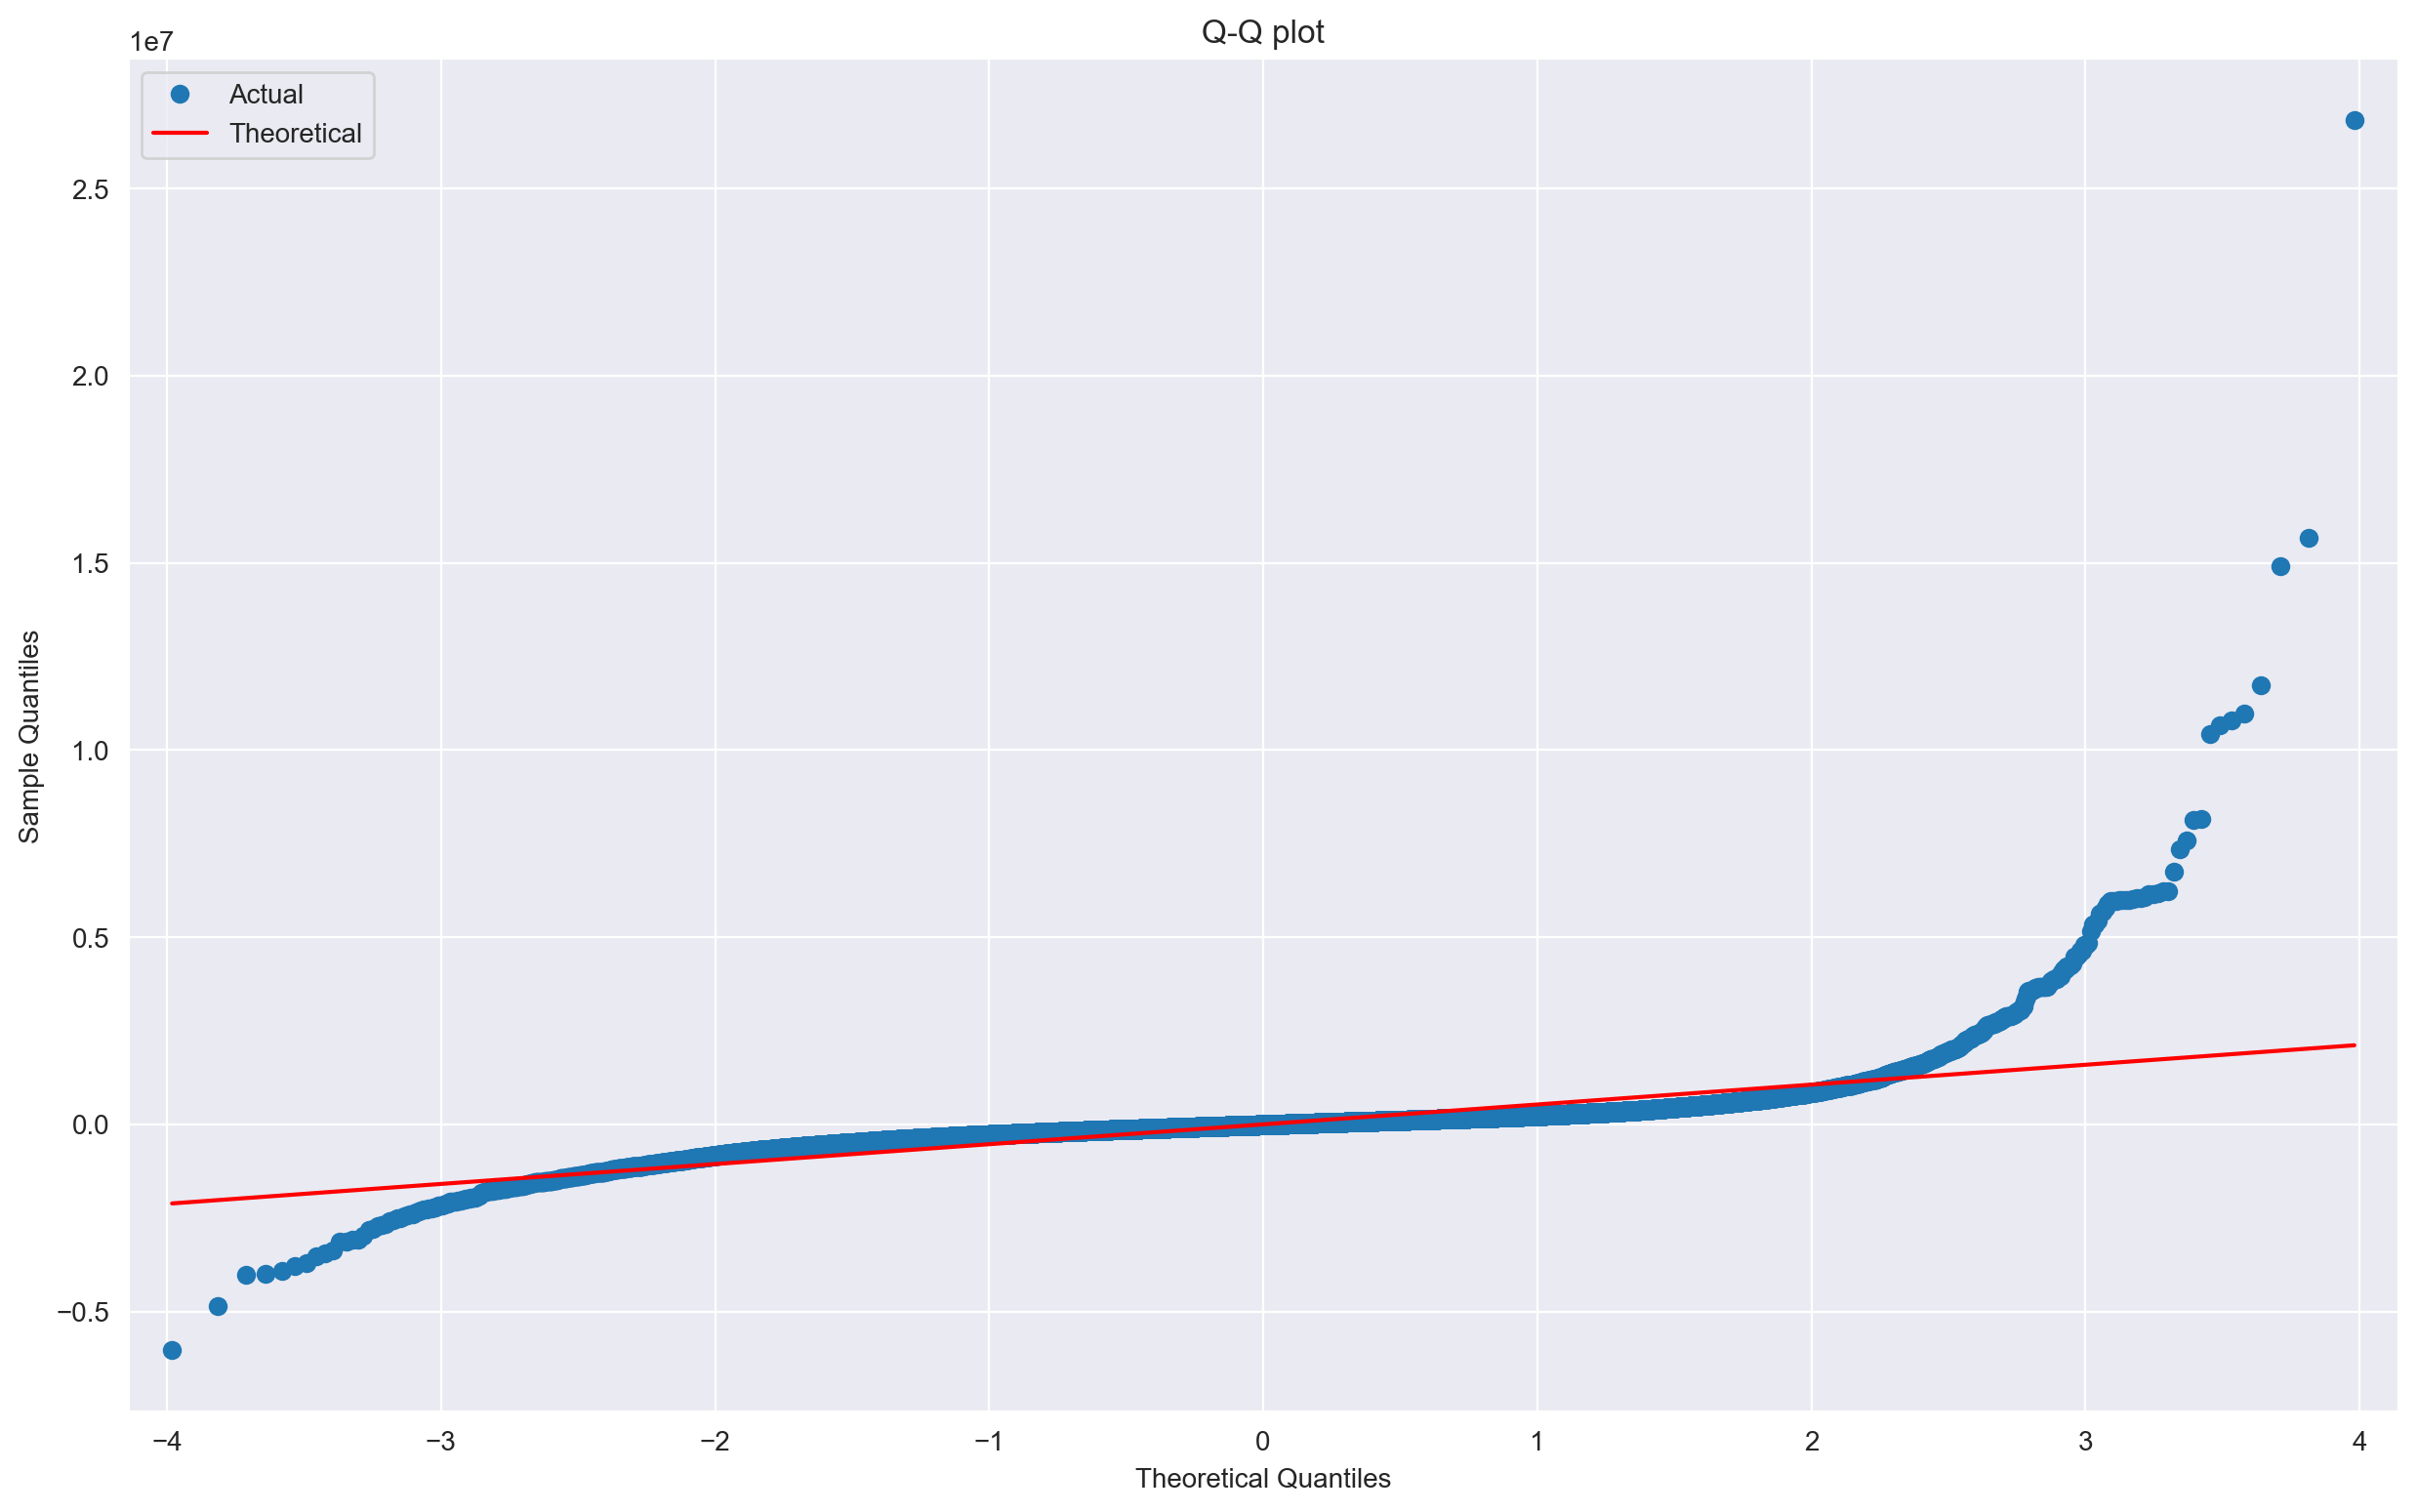

In [53]:
normality_of_residuals_test(results_4)

Potential solutions:
* nonlinear transformation of target variable or features
* remove/treat potential outliers
* it can happen that there are two or more subsets of the data having different statistical properties, in which case separate models might be considered

## Save for later use

In [54]:
df.to_csv('../data/02_modeling.csv', index=False)
X_4.to_csv('../data/02_model.csv', index=False)